# 데이터 준비

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torchtext

torchtext.disable_torchtext_deprecation_warning()

# 데이터셋 클래스 정의
class IMDBDataset(Dataset):
    def __init__(self, csv_file, tokenizer, vocab):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        tokens = self.tokenizer(review)
        token_ids = [self.vocab[token] for token in tokens if token in self.vocab]

        return torch.tensor(token_ids), torch.tensor(label)

def collate_batch(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    data = pad_sequence(data, batch_first=True, padding_value=0)  # 패딩 값은 0으로 설정
    targets = torch.tensor(targets)
    return data, targets


# 데이터 전처리 및 준비
data = pd.read_csv('C:/Users/do150/Desktop/IMDB Dataset.csv')
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# train 데이터셋 줄이기
train_data = data.iloc[:5000]  # 처음 5000개의 데이터만 사용

# train, valid, test 데이터셋 생성
train_data.to_csv('train.csv', index=False)
valid_data, test_data = train_test_split(data.iloc[5000:], test_size=0.5, random_state=42)
valid_data.to_csv('valid.csv', index=False)
test_data.to_csv('test.csv', index=False)

# 데이터셋과 데이터 로더 설정
batch_size = 16
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_data['review']), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

train_dataset = IMDBDataset('train.csv', tokenizer, vocab)
valid_dataset = IMDBDataset('valid.csv', tokenizer, vocab)
test_dataset = IMDBDataset('test.csv', tokenizer, vocab)

# Transformer용 DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


AttributeError: module 'torchtext' has no attribute 'disable_torchtext_deprecation_warning'

# Transformer

In [ ]:
# Transformer 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(embed_dim, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.fc = nn.Linear(embed_dim, 2)  # 이진 분류 (긍정, 부정)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)  # 모든 시간 단계의 평균을 취함
        output = self.fc(output)
        return output

# 모델 초기화 및 하이퍼파라미터 설정
vocab_size = len(vocab)
embed_dim = 256
nhead = 8
nhid = 512
nlayers = 6
dropout = 0.2

model = TransformerModel(vocab_size, embed_dim, nhead, nhid, nlayers, dropout)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for inputs, labels in tqdm(iterator, desc='Training', leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(iterator, desc='Evaluating', leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
# 모델 훈련 및 검증
epochs = 10
best_valid_loss = float('inf')
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)

    if train_loss < best_valid_loss:
        best_valid_loss = train_loss
        torch.save(model.state_dict(), 'transformer_model.pth')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

In [ ]:
# 테스트 데이터셋에서 평가
model.load_state_dict(torch.load('transformer_model.pth'))
test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}')

# 임베딩 + 포지셔널 인코딩

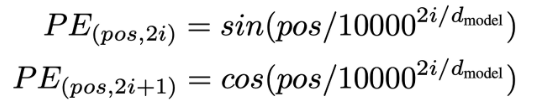

In [ ]:
import numpy as np
import math

# 단어 임베딩 생성 (단순히 랜덤하게 초기화)
def create_embeddings(vocab_size, embedding_dim):
    return np.random.rand(vocab_size, embedding_dim)

# 포지셔널 인코딩 생성
def positional_encoding(seq_len, d_model):
    # 실제 식으로 짠 코드와 해당 코드의 경우 차이가 있을 수 있음
    pe = np.zeros((seq_len, d_model))
    position = np.arange(0, seq_len).reshape(-1, 1)
    # 10000^(2i/d_model)
    # 처음 np.arange : 2i
    # np.exp와 log를 사용하여 값 계산
    # / d_model : 위 식에서 d_model과 동일
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    
    # 2i 일 때 sin함수, 2i+1 일 때 cos함수 사용
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

# 배치 중 하나 선택
batch = next(iter(train_loader))
token_ids_batch, labels_batch = batch

# 배치 중 가장 긴 문장의 길이 구하기
seq_len = max(token_ids_batch.size(1) for token_ids_batch, _ in train_loader)

# 첫 번째 샘플 선택
token_ids = token_ids_batch[0].numpy()

vocab_size = len(vocab)
embedding_dim = 8  # 임베딩 차원

# 단어 임베딩 생성
embeddings = create_embeddings(vocab_size, embedding_dim)

# 입력 토큰의 임베딩 벡터
input_embeddings = embeddings[token_ids]

# 포지셔널 인코딩 추가
positional_encodings = positional_encoding(seq_len, embedding_dim)
output_embeddings = input_embeddings + positional_encodings[:len(token_ids)]

# 출력 형식을 소수점 이하 4자리로 설정
np.set_printoptions(precision=4, suppress=True)

print("Positional Encodings:\n", positional_encodings)
print("Output Embeddings with Positional Encoding:\n", output_embeddings)

# 쿼리, 키, 값 + 셀프 어텐션

In [ ]:
# Query, Key, Value 계산
# 3가지 값을 구할 때 입력의 경우 동일하며 가중치가 내적되면서 값이 달라짐
def calculate_qkv(embeddings, d_k):
    # 3가지 값을 구할 시 linear 연산이 이루어지며 이를 위해서 초기 가중치 설정
    W_q = np.random.rand(d_k, d_k)
    W_k = np.random.rand(d_k, d_k)
    W_v = np.random.rand(d_k, d_k)
    
    # 내적 연산을 통해서 3가지 값을 구함
    Q = np.dot(embeddings, W_q)
    K = np.dot(embeddings, W_k)
    V = np.dot(embeddings, W_v)
    
    return Q, K, V

# 어텐션 스코어 계산
# 셀프 어텐션을 위한 식을 그대로 구현
def attention(Q, K, V):
    d_k = Q.shape[-1]
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    output = np.dot(attention_weights, V)
    
    return output, attention_weights

Q, K, V = calculate_qkv(output_embeddings, embedding_dim)

# 어텐션 계산
output, attention_weights = attention(Q, K, V)

print("Attention Output:\n", output)
print("Attention Weights:\n", attention_weights)

# 포지셔널 인코딩
### 포지셔널 인코딩이 제대로 되었는지 확인하기 위한 코드

In [ ]:
import numpy as np
import math

# 포지셔널 인코딩 생성
def positional_encoding(seq_len, d_model):
    pe = np.zeros((seq_len, d_model))
    position = np.arange(0, seq_len).reshape(-1, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

# 입력 토큰의 수와 임베딩 차원 설정
seq_len = 10  # 입력 시퀀스 길이
embedding_dim = 8  # 임베딩 차원

# 임베딩 값이 모두 0인 입력 생성
input_embeddings = np.zeros((seq_len, embedding_dim))
print("Input Embeddings (All Zeros):\n", input_embeddings)

# 포지셔널 인코딩 추가
positional_encodings = positional_encoding(seq_len, embedding_dim)
output_embeddings = input_embeddings + positional_encodings

print("Positional Encodings:\n", positional_encodings)
print("Output Embeddings with Positional Encoding:\n", output_embeddings)
